#### pyWaPOR vs. WaPOR

In this notebook we'll make an comparison between dekadal Evapotranspiration data from WaPOR and from pyWaPOR.

First we install pywapor, in case it's not installed yet.

In [1]:
!pip install pywapor==3.1.5 --quiet

Next we'll define a couple of basic variables, which were explained in the introduction notebook.

In [2]:
import pywapor

project_folder = r"/Users/hmcoerver/pywapor_notebooks_6"
timelim = ["2021-07-01", "2021-07-11"]
latlim = [28.9, 29.7]
lonlim = [30.2, 31.2]

Then we run `pre_et_look`, to generate an ET map for the first dekad of July 2021.

In [3]:
ds_in = pywapor.pre_et_look.main(project_folder, latlim, lonlim, timelim)

> PRE_ET_LOOK
    --> Collecting `ndvi` from `MODIS.MOD13Q1.061`.
        --> Applying 'mask_qa' to `ndvi`.              
        --> Saving merged data.
            > peak-memory-usage: 2.5MB, execution-time: 0:00:02.078004.
            > chunksize|dimsize: [time: 1|1, y: 418|418, x: 523|523]
            > timesize: 1 [2021-07-04T00:00, ..., 2021-07-04T00:00]
    --> Collecting `ndvi` from `MODIS.MYD13Q1.061`.
        --> Applying 'mask_qa' to `ndvi`.              
        --> Saving merged data.
            > peak-memory-usage: 5.0MB, execution-time: 0:00:02.078531.
            > chunksize|dimsize: [time: 2|2, y: 418|418, x: 523|523]
            > timesize: 2 [2021-06-26T00:00, ..., 2021-07-12T00:00]
    --> Collecting `r0` from `MODIS.MCD43A3.061`.
        --> Applying 'shortwave_r0' to `r0`.           
        --> Applying 'mask_qa' to `r0`.
        --> Saving merged data.
            > peak-memory-usage: 16.9MB, execution-time: 0:00:02.102101.
            > chunksize|dimsize: [tim

Then we run `et_look`.

In [4]:
ds = pywapor.et_look.main(ds_in, export_vars = ["et_24_mm"])

> ET_LOOK
    --> Running `et_look` (v2).
    --> Calculating `declination`.
    --> Calculating `inverse_earth_sun_distance`.
    --> Calculating `vegetation_cover`.
    --> Calculating `leaf_area_index`.
    --> Calculating `effective_leaf_area_index`.
    --> Calculating `soil_fraction`.
    --> Calculating `latitude_rad`.
    --> Calculating `sunset_hour_angle`.
    --> Calculating `daily_solar_radiation_toa_flat`.
    --> Calculating `transmissivity`.
    --> Calculating `stress_radiation`.
    --> Calculating `air_pressure_kpa2mbar`.
    --> Calculating `air_pressure_daily`.
    --> Calculating `air_pressure`.
    --> Calculating `vapour_pressure_from_specific_humidity_daily`.
    --> Calculating `vapour_pressure_from_specific_humidity`.
    --> Calculating `saturated_vapour_pressure`.
    --> Calculating `vapour_pressure_deficit_daily`.
    --> Calculating `vapour_pressure_deficit`.
    --> Calculating `stress_vpd`.
    --> Calculating `stress_temperature`.
    --> Calculating `

Now that we have the pyWaPOR ET map, we still need the WaPOR map in order to make a comparison. We can download this particular map like this (check [this](https://colab.research.google.com/drive/1V25DILFeeEjJ4cn-VuIzdZ0O_dgtbDio?usp=sharing) notebook for a more in-depth explanation of this code).

In [5]:
import requests
from osgeo import gdal
import os

cubecode = "L1_AETI_D"
rasterid = "L1_AETI_2119"

authorization_request_url = "https://io.apps.fao.org/gismgr/api/v1/iam/sign-in"
authorization_headers = {"X-GISMGR-API-KEY": pywapor.collect.accounts.get("WAPOR")[0]}
authorization_request_response = requests.post(authorization_request_url, headers = authorization_headers)
authorization_request_response.raise_for_status()
access_token = authorization_request_response.json()["response"]["accessToken"]

tif_request_url = f"https://io.apps.fao.org/gismgr/api/v1/download/WAPOR_2?requestType=MAPSET_RASTER&cubeCode={cubecode}&rasterId={rasterid}"
tif_headers = {"Authorization": f"Bearer {access_token}"}
tif_request_response = requests.get(tif_request_url, headers = tif_headers)
tif_request_response.raise_for_status()
tif_url = tif_request_response.json()["response"]["downloadUrl"]

bounding_box = [lonlim[0], latlim[1], lonlim[1], latlim[0]]
translate_options = gdal.TranslateOptions(projWin=bounding_box, bandList=[1])
wapor_file = os.path.join(project_folder, "wapor_eta.tif")
ds = gdal.Translate(wapor_file, f"/vsicurl/{tif_url}", options = translate_options)
ds.FlushCache()
ds = None

Next, lets have a look at the two datasets side by side.

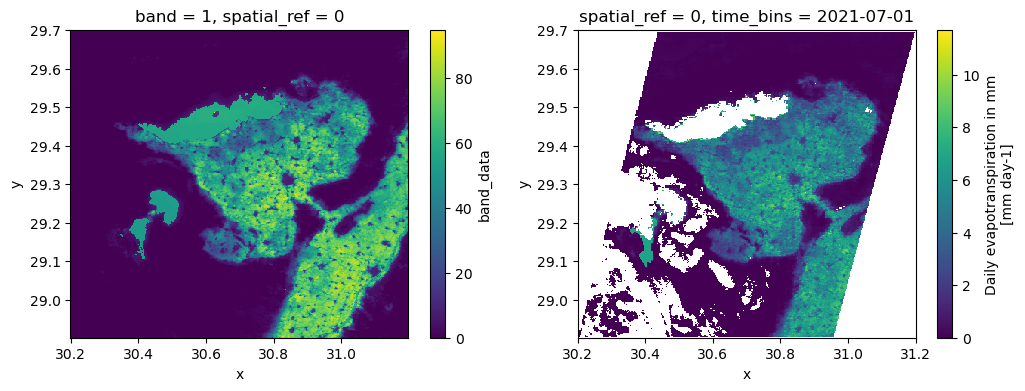

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

ds = xr.open_dataset(r"/Users/hmcoerver/pywapor_notebooks_6/et_look_out.nc", decode_coords="all")

wapor_da = xr.open_dataset(wapor_file).isel(band = 0)["band_data"]
pywapor_da = ds.et_24_mm.isel(time_bins=0)

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
wapor_da.plot(ax=axes[0])
pywapor_da.plot(ax=axes[1])

As you can see, the values in WaPOR seems to be about 10 times larger than pyWaPOR. We need to apply a scale factor to WaPOR.

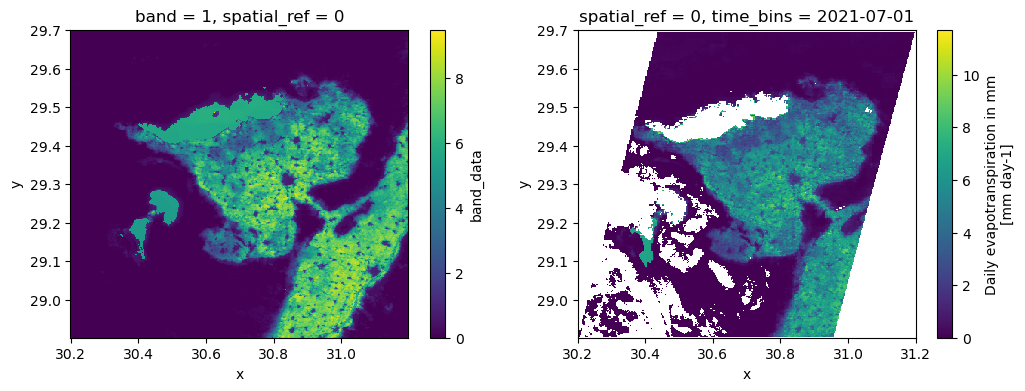

In [7]:
wapor_da= wapor_da * 0.1

fig, axes = plt.subplots(ncols=2, figsize=(12,4))
wapor_da.plot(ax=axes[0])
pywapor_da.plot(ax=axes[1])

We can also have a look at some other metadata.

In [8]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"count: {raster.count().item()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

print("WaPOR Raster:\n-------------")
print_raster(wapor_da)
print("pyWaPOR Raster:\n---------------")
print_raster(pywapor_da)

WaPOR Raster:
-------------
shape: (358, 448)
resolution: (0.00223214286, -0.00223214286)
bounds: (30.198660777060002, 28.901785714360003, 31.198660778340006, 29.700892858240003)
count: 160384
CRS: EPSG:4326

pyWaPOR Raster:
---------------
shape: (418, 523)
resolution: (0.001912839058868034, -0.0019128390588680415)
bounds: (30.199746759913452, 28.90147493739254, 31.200161587701434, 29.70104166399938)
count: 136177
CRS: EPSG:4326



Projections are the same, but shape and pixel sizes are slighly different. Let make them match with eachother, so that we can make a comparison between the two arrays.

In [9]:
wapor_da = wapor_da.rio.reproject_match(pywapor_da)

pywapor_da = pywapor_da.where(wapor_da.notnull())
wapor_da = wapor_da.where(pywapor_da.notnull())

WaPOR Raster:
-------------
shape: (418, 523)
resolution: (0.001912839058868034, -0.0019128390588680415)
bounds: (30.199746759913452, 28.90147493739254, 31.200161587701434, 29.70104166399938)
count: 136177
CRS: EPSG:4326

pyWaPOR Raster:
---------------
shape: (418, 523)
resolution: (0.001912839058868034, -0.0019128390588680415)
bounds: (30.199746759913452, 28.90147493739254, 31.200161587701434, 29.70104166399938)
count: 136177
CRS: EPSG:4326



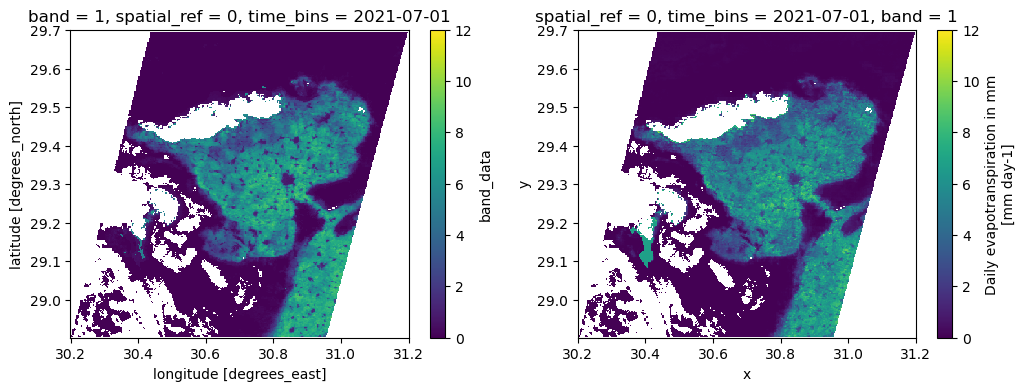

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))
wapor_da.plot(ax=axes[0], vmin = 0, vmax = 12)
pywapor_da.plot(ax=axes[1], vmin = 0, vmax = 12)

print("WaPOR Raster:\n-------------")
print_raster(wapor_da)
print("pyWaPOR Raster:\n---------------")
print_raster(pywapor_da)

In [11]:
import numpy as np

def plot_hexbin(ax, arrays, xlabel = "", ylabel = ""):
    minmax = [np.min(arrays), np.max(arrays)]
    ax.plot(minmax, minmax, ":k", label = "1:1")
    ax.legend()
    hb = ax.hexbin(*arrays, bins = "log")
    ax.set_facecolor(plt.cm.get_cmap('viridis')(0.0))
    ax.get_figure().colorbar(hb, label = "Number of pixels [-]")
    ax.set_xlim(minmax)
    ax.set_ylim(minmax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    nse = pywapor.post_et_look.calc_nash_sutcliffe(arrays)[0]
    rmse = pywapor.post_et_look.calc_rmse(arrays)[0]
    r = pywapor.post_et_look.calc_pearson_correlation(arrays)[0]
    ax.set_title(f"r: {r:.3f}, nse: {nse:.3f}, rmse: {rmse:.3f}")

Finally, lets make a scatter plot to see the differences a bit better.

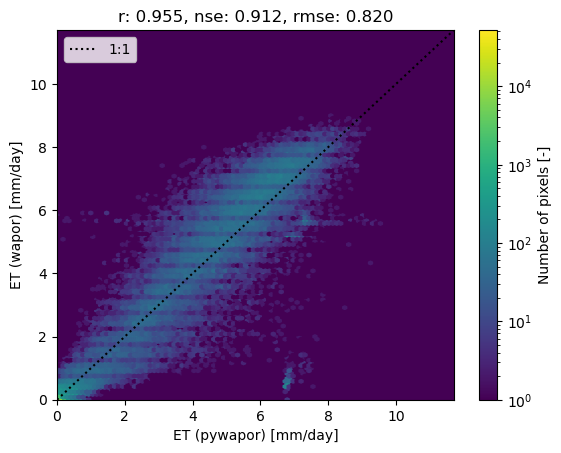

In [12]:
arrays = np.array([
    pywapor_da.stack({"pixel": ("y", "x")}).dropna("pixel"),
    wapor_da.stack({"pixel": ("y", "x")}).dropna("pixel")
])

fig = plt.figure()
ax = fig.gca()
plot_hexbin(ax, arrays,
            "ET (pywapor) [mm/day]", 
            "ET (wapor) [mm/day]")

Although there is some variance, the two maps are very similar. `et_look` is identical to the model used to create the WaPOR data, but `pre_et_look` is not. The solar-radiation (ra_24) product used in pyWaPOR is differnt from WaPOR as well. This variance can thus mainly be explained by differences in the preprocessing of the `et_look` input data.